# My last.fm statistics

From wikipedia:  

> Last.fm is a music website, founded in the United Kingdom in 2002. Using a music recommender system called "Audioscrobbler", Last.fm builds a detailed profile of each user's musical taste by recording details of the tracks the user listens to.

I discovered [last.fm](http://www.last.fm/) and started using it way too late - in December 2012, ten years after its launch. I've downloaded Audioscrobbler plugin for my favourite music player - [foobar2000](https://foobar2000.org/), and started *scrobbling* songs I listen to.

Over the time, as the library of artists/albums/songs I listen to got bigger, my music tastes became more recognizable and last.fm started to recommend me artists I didn't listen but I might like them. This allowed me to discover lots of "small" bands and to broaden my music library.

In this analysis, I've explored past four years of my listening history with foobar2000 - no other services (youtube, internet radio, etc.) are included.

General notes:
* I've used [lastfm to csv](https://benjaminbenben.com/lastfm-to-csv/) to get the data
* 49k total scrobbles
* 594 different artists, 1454 different albums, 14k different songs (after cleaning the data)
* around 3.5% of the data had missing album value (0.3% after cleaning)
* most of the time I listen albums from the beginning to the end (in contrast to listening just particular songs), which was very beneficial for filling out the missing album values
* some artists were having different values for their name, depending on (the version of) an album

Data cleaning and preparation took me the most time because I wanted results to be as meaningful as possible, but if you want to skip it (I can't blame you), go to the [charts](#Charts) part of the notebook.

Contents:
* [Data preparation](#Data-preparation) - boring stuff
* [Charts](#Charts) - colorfull stuff
* [Conclusions](#Conclusions) - TL;DR stuff

# Data preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as d
import pytz


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 7.5)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

In [3]:
df = pd.read_csv('./datasets/lastfm.csv', header=None, encoding='utf-8')
df.columns = ['Artist', 'Album', 'Song', 'Date']
df.head()

,Artist,Album,Song,Date
0,Morcheeba,Big Calm,Fear and Love,22 Aug 2016 19:08
1,Morcheeba,Big Calm,Diggin' a Watery Grave,22 Aug 2016 19:06
2,Morcheeba,Big Calm,Friction,22 Aug 2016 19:02
3,Morcheeba,Big Calm,Over and Over,22 Aug 2016 19:00
4,Morcheeba,Big Calm,Bullet Proof,22 Aug 2016 18:55


In [4]:
df['Date'] = pd.to_datetime(df.Date)

df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49298 entries, 0 to 49297
Data columns (total 4 columns):
Artist    49298 non-null object
Album     47503 non-null object
Song      49298 non-null object
Date      49298 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB


## Artist cleaning

In [5]:
# long name could indicate a value that needs to be corrected
df.Artist[df.Artist.map(len) > 30].unique()

array(['Tommy FlanaganJohn ColtraneKenny Burrell',
       'G 3 feat. Joe Satriani Steve Vai Eric Johnson',
       'Renaud Garcia-Fons & Jean-Louis Matinier',
       'Carlos Santana & Mahavishnu John McLaughlin',
       'Cream - Live Cream Vols. I & II (MFSL UDCD 2-635)',
       'Emmylou Harris Alison Krauss & Gillian Welch',
       'Danger Mouse; David Lynch; Sparklehorse',
       'Danger Mouse; Sparklehorse; Vic Chesnutt',
       'Danger Mouse; Sparklehorse; Suzanne Vega',
       'Danger Mouse; Mark Linkous; Nina Persson; Sparklehorse',
       'Danger Mouse; James Mercer; Jim Mercer; Sparklehorse',
       'Danger Mouse; Jason Lytle; Sparklehorse',
       'Danger Mouse; Iggy Pop; Sparklehorse',
       'Black Francis; Danger Mouse; Sparklehorse',
       'Danger Mouse; Julian Casablancas; Sparklehorse',
       'Danger Mouse; Gruff Rhys; Sparklehorse',
       'Danger Mouse; Sparklehorse; The Flaming Lips',
       'Thelonious Monk with John Coltrane',
       'Symphony No. 2 - Vivacissimo -

In [6]:
df.loc[df.Artist.str.contains('FlanaganJohn'), 'Artist'] = 'John Coltrane'
df.loc[df.Artist.str.contains('Garcia-Fons'), 'Artist'] = 'Renaud Garcia-Fons'
df.loc[df.Artist.str.contains('Santana'), 'Artist'] = 'Santana'
df.loc[df.Artist.str.contains('Danger Mouse') & (df.Album.str.contains('Dark Night')), 'Artist'] = 'Danger Mouse'
df.loc[df.Artist.str.contains('Thelonious Monk'), 'Artist'] = 'Thelonious Monk'
df.loc[df.Artist.str.contains('Rundek'), 'Artist'] = 'Darko Rundek'
df.loc[df.Artist.str.contains('Woodstock'), 'Artist'] = 'Woodstock'
df.loc[df.Artist.str.contains('Cash'), 'Artist'] = 'Johnny Cash'
df.loc[df.Artist.str.contains('RKV'), 'Artist'] = 'Ekatarina Velika'

## Filling and cleaning album data

### Part I: Automatic part

In [7]:
# clean all brackets and parenthesis ((), [], {}) which have number in them (\d+) or one of given words
regexp = '(\(|\[|\{).*(\d+|remaster|deluxe|bonus|flac|vinyl|mfsl|shm|edition|version|rem|extended)+.*(\)|\]|\})'
condition = (df.Album.notnull() & df.Album.str.contains(regexp, case=False))

clean_album_name = lambda x: x.split('[')[0].split('(')[0].split('{')[0].strip()
df.loc[condition, 'Album'] = df[condition]['Album'].map(clean_album_name)

c:\program files\python\lib\site-packages\ipykernel\__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


In [8]:
def find_album(x):
    """
    Try to find an album for a song with unknown album.
    If an artist has the same song on some known album(s),
    return the most listened album.
    """
    condition = (df.Artist == x.Artist) & (df.Song == x.Song) & (df.Album.notnull())
    try:
        return df.Album[condition].value_counts().index[0]
    except IndexError:
        return np.nan


def fill_album(group):
    """
    Group is defined as songs by the same artist 
    listened on the same day.
    If the group has just one value for the guessed album, 
    use that as an value for the album.
    Else, the album remains unknown.
    """
    if group.Album_guess.unique().shape[0] == 1:
        album = group.Album_guess.values[0]
        group['Album'] = album
        group['Album_guess'] = -1
    return group

unknown_album = df.Album.isnull()
df.loc[unknown_album, 'Album_guess'] = df[unknown_album].apply(find_album, axis=1)

album_guess = df.Album_guess.notnull()
group = [df.Artist, df.Date.dt.date]
df.loc[album_guess] = df[album_guess].groupby(group).apply(fill_album)


df.loc[df.Album_guess == -1, 'Album_guess'] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49298 entries, 0 to 49297
Data columns (total 5 columns):
Artist         49298 non-null object
Album          48515 non-null object
Song           49298 non-null object
Date           49298 non-null datetime64[ns]
Album_guess    316 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 1.9+ MB


In [9]:
start = df_original[df_original.Album.isnull()].shape[0]
part_I = df[df.Album.isnull()].shape[0]

print("Filled album data for {} scrobbles.".format(start - part_I))

Filled album data for 1012 scrobbles.


### Part II: Semi-automatic part

In [10]:
df.Artist[df.Album_guess.notnull()].sort_values().unique()

array(['Coldplay', 'Cream - Live Cream Vols. I & II (MFSL UDCD 2-635)',
       'Curtis Mayfield', 'Deep Purple', 'Dire Straits', 'Johnny Cash',
       'Red Hot Chili Peppers', 'The White Stripes'], dtype=object)

#### Coldplay

In [11]:
artist = 'Coldplay'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

df.loc[condition]

,Artist,Album,Song,Date,Album_guess
44492,Coldplay,NaN,Amsterdam,2013-02-10 14:51:00,A Rush of Blood to the Head
44493,Coldplay,NaN,In My Place,2013-02-10 14:46:00,A Rush of Blood to the Head
44494,Coldplay,NaN,Clocks,2013-02-10 14:41:00,A Rush of Blood to the Head
44495,Coldplay,NaN,Yellow,2013-02-10 14:35:00,Parachutes
44497,Coldplay,NaN,Everything's Not Lost,2013-02-10 14:21:00,Parachutes
44498,Coldplay,NaN,Shiver,2013-02-10 14:16:00,Parachutes
44501,Coldplay,NaN,A Rush of Blood to the Head,2013-02-10 14:00:00,A Rush of Blood to the Head
44502,Coldplay,NaN,God Put a Smile Upon Your Face,2013-02-10 13:55:00,A Rush of Blood to the Head
44503,Coldplay,NaN,Politik,2013-02-10 13:49:00,A Rush of Blood to the Head


In [12]:
df.loc[condition, 'Album'] = 'Live 2003'

#### Cream

In [13]:
artist = 'Cream'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

df.loc[condition]

,Artist,Album,Song,Date,Album_guess
43550,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Steppin' Out,2013-02-26 22:21:00,Volume II
43551,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Sunshine of Your Love,2013-02-26 21:48:00,Volume II
43552,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Tales of Brave Ulysses,2013-02-26 21:43:00,Volume II
43553,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Politician,2013-02-26 21:38:00,Volume II
43554,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,White Room,2013-02-26 21:33:00,Volume II
43555,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Deserted Cities of the Heart,2013-02-26 21:28:00,Volume II
43556,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Lawdy Mama,2013-02-26 21:25:00,Volume I
43557,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Rollin' and Tumblin',2013-02-26 21:19:00,Volume I
43558,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Sweet Wine,2013-02-26 20:59:00,Volume I
43559,Cream - Live Cream Vols. I & II (MFSL UDCD 2-635),NaN,Sleepy Time Time,2013-02-26 20:52:00,Volume I


In [14]:
df.loc[condition, 'Album'] = 'Live Cream - {}'.format(df.Album_guess)

# Change wrong artist name where applies
df.loc[df.Artist.str.contains('Live Cream Vols. I & II'), 'Artist'] = 'Cream'

#### Curtis Mayfield

In [15]:
artist = 'Curtis'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

df.loc[condition]

,Artist,Album,Song,Date,Album_guess
40817,Curtis Mayfield,NaN,Stone Junkie,2013-04-09 19:19:00,Curtis Mayfield Live!
40818,Curtis Mayfield,NaN,(Don't Worry) If There's A Hell Bellow We're A...,2013-04-09 19:10:00,Curtis Mayfield Live!
40819,Curtis Mayfield,NaN,We The People Who Are Darker Than Blue,2013-04-09 19:03:00,Curtis Mayfield Live!
40820,Curtis Mayfield,NaN,Rap,2013-04-09 19:01:00,Curtis Mayfield Live!
40821,Curtis Mayfield,NaN,The Makings Of You,2013-04-09 18:58:00,Curtis
40822,Curtis Mayfield,NaN,Gypsy Woman,2013-04-09 18:54:00,Curtis Mayfield Live!
40823,Curtis Mayfield,NaN,Check Out Your Mind,2013-04-09 18:50:00,Curtis Mayfield Live!
40824,Curtis Mayfield,NaN,Stare And Stare,2013-04-09 18:28:00,Curtis Mayfield Live!
40825,Curtis Mayfield,NaN,Rap,2013-04-09 18:27:00,Curtis Mayfield Live!
40826,Curtis Mayfield,NaN,People Get Ready,2013-04-09 18:24:00,Curtis Mayfield Live!


In [16]:
df.loc[condition, 'Album'] = 'Curtis'

#### Deep Purple

In [17]:
artist = 'Deep'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

group = df.loc[condition].groupby(df.Date.dt.date)
group.Album_guess.value_counts()

Date        Album_guess                
2012-12-02  Made In Japan                  4
            Machine Head                   3
2013-03-03  Shades of Deep Purple          8
            Deep Purple                    6
2013-04-27  Deep Purple In Rock            6
            Made In Japan                  1
2013-09-01  Fireball                       4
            Live At The Olympia '96 CD1    2
            Made In Japan                  1
2013-09-09  Made In Japan                  4
            Machine Head                   3
2013-12-07  Live At The Olympia '96 CD1    7
            Machine Head                   2
            Made In Japan                  2
            Deep Purple In Rock            1
2015-10-12  Made In Japan                  4
            Machine Head                   3
dtype: int64

In [18]:
# two different albums on this date
condition = df.Artist.str.contains(artist) & (df.Date.dt.date == d.date(2013, 3, 3))
df.loc[condition, 'Album'] = df.Album_guess
df.loc[condition, 'Album_guess'] = np.nan


# on other dates, mode of the guessed albums is the correct album
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()
group = df.loc[condition].groupby(df.Date.dt.date)

for listening_date in group.indices.keys():
    albums = group.Album_guess.value_counts().unstack()
    df.loc[condition & (df.Date.dt.date == listening_date), 'Album'] = np.argmax(albums.ix[listening_date])

#### Dire Straits

In [19]:
artist = 'Dire Straits'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

group = df.loc[condition].groupby(df.Date.dt.date)
group.Album_guess.value_counts()

Date        Album_guess                        
2013-01-20  Making Movies                           7
            Alchemy: Dire Straits Live Part One     2
            Love Over Gold                          2
            Alchemy: Dire Straits Live              1
2013-03-01  Dire Straits                           10
            Making Movies                           3
            Alchemy: Dire Straits Live Part One     2
            Alchemy: Dire Straits Live              1
            Communiqué                              1
2013-03-02  Alchemy: Dire Straits Live              1
            Making Movies                           1
2013-07-14  Making Movies                           4
            Alchemy: Dire Straits Live              2
            Alchemy: Dire Straits Live Part One     2
            Communiqué                              1
            Dire Straits                            1
2013-12-04  Dire Straits                            2
            Live At The BBC       

In [20]:
# two different albums on this date
condition = (df.Artist.str.contains(artist) & 
             (df.Date.dt.date == d.date(2013, 1, 20))
            )
album_names = lambda x: x if x == 'Making Movies' else 'Love Over Gold'

df.loc[condition, 'Album'] = df.loc[condition, 'Album_guess'].map(album_names)
df.loc[condition, 'Album_guess'] = np.nan


# two different albums on this date
condition = (df.Artist.str.contains(artist) & 
             (df.Date.dt.date == d.date(2013, 3, 1))
            )
album_names = lambda x: x if x == 'Dire Straits' else 'Alchemy: Dire Straits Live'

df.loc[condition, 'Album'] = df.loc[condition, 'Album_guess'].map(album_names)
df.loc[condition, 'Album_guess'] = np.nan


# Alchemy: Dire Straits Live
condition = (df.Artist.str.contains(artist) & 
             (df.Date.dt.date == d.date(2013, 7, 14))
            )
df.loc[condition, 'Album'] = 'Alchemy: Dire Straits Live'
df.loc[condition, 'Album_guess'] = np.nan


# Live at the BBC
dates = [
    d.date(2013, 12, 4),
    d.date(2014, 5, 25),
    d.date(2016, 8, 13),   
]
condition = (df.Artist.str.contains(artist) & 
             df.Album_guess.notnull() & 
             df.Date.dt.date.isin(dates)
            )
df.loc[condition, 'Album'] = 'Live At The BBC'
df.loc[condition, 'Album_guess'] = np.nan


# Love Over Gold
dates = [
    d.date(2014, 3, 6),
    d.date(2015, 10, 15),  
]
condition = (df.Artist.str.contains(artist) & 
             df.Album_guess.notnull() & 
             df.Date.dt.date.isin(dates)
            )
df.loc[condition, 'Album'] = 'Love Over Gold'
df.loc[condition, 'Album_guess'] = np.nan

#### Johnny Cash

In [21]:
artist = 'Cash'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

group = df.loc[condition].groupby(df.Date.dt.date)

group.Album_guess.value_counts()

Date        Album_guess                                  
2013-08-03  At Folsom Prison                                  2
            Johnny Cash With His Hot and Blue Guitar          2
            I Walk The Line                                   1
2013-08-11  Johnny Cash With His Hot and Blue Guitar          9
            Sings the Songs That Made Him Famous              8
            All Aboard the Blue Train                         4
            American Recordings II - Unchained                1
            At Folsom Prison                                  1
            I Walk The Line                                   1
2013-08-13  At Folsom Prison                                  3
            American Recordings IV - The Man Comes Around     1
2013-12-25  American IV: The Man Comes Around                 7
            American Recordings IV - The Man Comes Around     6
            At Folsom Prison                                  1
2015-03-22  At Folsom Prison                  

In [22]:
# two different albums on this date
condition = (df.Artist.str.contains('Cash') & 
             (df.Date.dt.date == d.date(2013, 8, 11))
            )
album_names = lambda x: x if x == 'Sings the Songs' else 'Johnny Cash With His Hot and Blue Guitar'

df.loc[condition, 'Album'] = df.loc[condition, 'Album_guess'].map(album_names)
df.loc[condition, 'Album_guess'] = np.nan


# American IV
condition = (df.Artist.str.contains('Cash') & 
             (df.Date.dt.date == d.date(2013, 12, 25))
            )
df.loc[condition, 'Album'] = 'American Recordings IV - The Man Comes Around'
df.loc[condition, 'Album_guess'] = np.nan

#### RHCP

In [23]:
artist = 'Red Hot'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

df[condition]

,Artist,Album,Song,Date,Album_guess
30324,Red Hot Chili Peppers,NaN,Yertle the Turtle,2013-11-09 17:47:00,Freaky Styley
30325,Red Hot Chili Peppers,NaN,Sex Rap,2013-11-09 17:45:00,Freaky Styley
30326,Red Hot Chili Peppers,NaN,Catholic School Girls Rule,2013-11-09 17:43:00,Freaky Styley
30327,Red Hot Chili Peppers,NaN,Lovin' and Touchin',2013-11-09 17:42:00,Freaky Styley
30328,Red Hot Chili Peppers,NaN,Battle Ship,2013-11-09 17:41:00,Freaky Styley
30329,Red Hot Chili Peppers,NaN,The Brothers Cup,2013-11-09 17:37:00,Freaky Styley
30330,Red Hot Chili Peppers,NaN,Blackeyed Blonde,2013-11-09 17:34:00,Freaky Styley
30331,Red Hot Chili Peppers,NaN,Freaky Styley,2013-11-09 17:31:00,Freaky Styley
30332,Red Hot Chili Peppers,NaN,Nevermind,2013-11-09 17:28:00,Freaky Styley
30333,Red Hot Chili Peppers,NaN,If You Want Me to Stay,2013-11-09 17:24:00,Freaky Styley


In [24]:
df.loc[condition, 'Album'] = df.Album_guess

#### The White Stripes

In [25]:
artist = 'White Stripes'
condition = df.Artist.str.contains(artist) & df.Album_guess.notnull()

df[condition]

,Artist,Album,Song,Date,Album_guess
39721,The White Stripes,NaN,I Fought Piranhas,2013-04-23 19:00:00,The White Stripes
39722,The White Stripes,NaN,St. James Infirmary Blues,2013-04-23 18:58:00,The White Stripes
39723,The White Stripes,NaN,Slicker Drips,2013-04-23 18:56:00,The White Stripes
39724,The White Stripes,NaN,Little People,2013-04-23 18:54:00,The White Stripes
39725,The White Stripes,NaN,One More Cup of Coffee,2013-04-23 18:51:00,The White Stripes
39726,The White Stripes,NaN,Screwdriver,2013-04-23 18:48:00,The White Stripes
39727,The White Stripes,NaN,Do,2013-04-23 18:45:00,The White Stripes
39728,The White Stripes,NaN,When I Hear My Name,2013-04-23 18:43:00,The White Stripes
39729,The White Stripes,NaN,Broken Bricks,2013-04-23 18:41:00,The White Stripes
39730,The White Stripes,NaN,Astro,2013-04-23 18:38:00,The White Stripes


In [26]:
df.loc[condition, 'Album'] = df.Album_guess

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49298 entries, 0 to 49297
Data columns (total 5 columns):
Artist         49298 non-null object
Album          48803 non-null object
Song           49298 non-null object
Date           49298 non-null datetime64[ns]
Album_guess    195 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 1.9+ MB


In [28]:
df.drop('Album_guess', inplace=True, axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49298 entries, 0 to 49297
Data columns (total 4 columns):
Artist    49298 non-null object
Album     48803 non-null object
Song      49298 non-null object
Date      49298 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB


### Part III: Semi-manual part

Let's deal with missing albums by top 10 artists who have the most plays without known album.

In [30]:
unknowns = df.Artist[df.Album.isnull()].groupby(df.Artist)
unknowns.count().sort_values(ascending=False)[:10]

Artist
LCD Soundsystem                                         79
Johnny Cash                                             74
Red Hot Chili Peppers                                   64
New Order                                               58
A.C.Jobim - B.Powell - J.Gilberto - Escolas de Samba    33
Psihomodo Pop                                           27
Drugi način                                             18
Neno Belan & Fiumens                                    14
Beastie Boys                                            13
Jovanotti                                               12
dtype: int64

#### Johnny Cash

In [31]:
artist = 'Johnny Cash'
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Song'].groupby(df.Date.dt.date).count()

Date
2013-07-15     1
2013-08-03    18
2013-08-12     8
2013-08-13    15
2015-03-22    18
2015-09-23    14
dtype: int64

In [32]:
folsom = ('At Folsom Prison', [d.date(2012, 12, 13), d.date(2013, 7, 15)])
quentin = ('At San Quentin', [d.date(2013, 8, 3), d.date(2015, 3, 22)])
orange = ('Orange Blossom Special', [d.date(2013, 8, 13)])


for name, dates in [folsom, quentin, orange]:
    condition = (df.Artist == artist) & (df.Album.isnull()) & (df.Date.dt.date.isin(dates))
    df.loc[condition, 'Album'] = name

#### LCD Soundsystem

In [33]:
artist = 'LCD Soundsystem'
df.Song[(df.Artist == artist) & (df.Album.isnull())].value_counts()

Daft Punk Is Playing at My House        7
On Repeat                               7
Too Much Love                           7
Movement                                7
Never As Tired As When I'm Waking Up    7
Tribulations                            7
Thrills                                 6
Great Release                           5
Disco Infiltrator                       5
Give It Up                              4
Losing My Edge                          4
Beat Connection                         4
Tired                                   4
Yeah (Crass Version)                    2
Yeah [Pretentious Version]              2
Yr city's a sucker [full version]       1
Name: Song, dtype: int64

In [34]:
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Album'] = 'LCD Soundsystem'

#### RHCP

In [35]:
artist = 'Red Hot Chili Peppers'
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Song'].groupby(df.Date.dt.date).count()

Date
2013-04-20    13
2013-05-11    13
2013-11-09     1
2013-11-13    12
2013-12-04    13
2015-04-27    12
dtype: int64

In [36]:
uplift_mofo = ('The Uplift Mofo Party Plan', [d.date(2013, 11, 13), d.date(2015, 4, 27)])
hot_minute = ('One Hot Minute', [d.date(2013, 4, 20), d.date(2013, 5, 11), d.date(2013, 12, 4)])


for name, dates in [uplift_mofo, hot_minute]:
    condition = (df.Artist == artist) & (df.Album.isnull()) & (df.Date.dt.date.isin(dates))
    df.loc[condition, 'Album'] = name

#### New Order

In [37]:
artist = 'New Order'
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Song'].groupby(df.Date.dt.date).count()

Date
2015-04-22     8
2015-06-23    11
2015-08-02     9
2015-09-04    11
2015-10-05     8
2015-10-29    11
dtype: int64

In [38]:
republic = ('Republic', [d.date(2015, 6, 23), d.date(2015, 9, 4), d.date(2015, 10, 29)])
pcl = ('Power, Corruption & Lies', [d.date(2015, 4, 22), d.date(2015, 10, 5)])
technique = ('Technique', [d.date(2015, 8, 2)])



for name, dates in [republic, pcl, technique]:
    condition = (df.Artist == artist) & (df.Album.isnull()) & (df.Date.dt.date.isin(dates))
    df.loc[condition, 'Album'] = name

#### A.C.Jobim - B.Powell - J.Gilberto - Escolas de Samba

In [39]:
artist = 'A.C.Jobim - B.Powell - J.Gilberto - Escolas de Samba'
df.loc[(df.Artist == artist), ['Artist', 'Album']] = artist.rsplit(' - ', maxsplit=1)

#### Psihomodo Pop

In [40]:
artist = 'Psihomodo Pop'
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Song'].groupby(df.Date.dt.date).count()

Date
2013-11-28    13
2014-07-17    14
dtype: int64

In [41]:
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Album'] = 'Srebrne Svinje'

#### Drugi način

In [42]:
artist = 'Drugi način'
df.Song[(df.Artist == artist) & (df.Album.isnull())].value_counts()

Nočas si strašo sama                   1
Lile su kiše                           1
Stoperi                                1
Žuti list                              1
Carstvo samoće                         1
Dođi do nas                            1
Piši mi                                1
Opet...                                1
Dileme                                 1
Na mom dlanu                           1
Napoleon                               1
Najbolje bi bilo da promijenim grad    1
Bijeg iz trećeg čina                   1
Stari grad                             1
Pobjegni već jednom                    1
Na svoj način                          1
Prave riječi                           1
Ringišpil                              1
Name: Song, dtype: int64

In [43]:
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Album'] = 'Drugi Način'

#### Neno Belan & Fiumens

In [44]:
artist = 'Neno Belan & Fiumens'
df.Song[(df.Artist == artist) & (df.Album.isnull())].value_counts()

Uspomene                   1
I Remember                 1
Ludo zaljubljen            1
Mesec moj i mesec tvoj     1
C'mon                      1
Mediterraneo               1
Brod                       1
Bellamore                  1
Život moj život tvoj       1
Mediterraneo (instr.)      1
Kavanna                    1
Brod (remix)               1
Tajna soba                 1
Ludo zaljubljen (remix)    1
Name: Song, dtype: int64

In [45]:
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Album'] = 'Luna & Stelle'

#### Beastie Boys

In [46]:
artist = 'Beastie Boys'
df.Song[(df.Artist == artist) & (df.Album.isnull())].value_counts()

Slow Ride                 1
Brass Monkey              1
Time to Get Ill           1
Rhymin & Stealin          1
Paul Revere               1
Girls                     1
Hold It Now Hit It        1
She's Crafty              1
No Sleep Till Brooklyn    1
The New Style             1
Posse in Effect           1
Fight for Your Right      1
Slow and Low              1
Name: Song, dtype: int64

In [47]:
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Album'] = 'Licensed To Ill'

#### Jovanotti

In [48]:
artist = 'Jovanotti'
df.Song[(df.Artist == artist) & (df.Album.isnull())].value_counts()

Ragazzo Fortunato             1
Puttane E Spose               1
Io No                         1
Sai Qual È Il Problema        1
Televisione Televisione       1
Benvenuti Nella Giungla       1
Non M'Annoio                  1
Ho Perso La Direzione         1
Vai con un po' di violenza    1
Il Rap                        1
Chissà se stai dormendo       1
Estate 1992                   1
Name: Song, dtype: int64

In [49]:
df.loc[(df.Artist == artist) & (df.Album.isnull()), 'Album'] = 'Lorenzo 1992'

### Misc. album cleaning

In [50]:
df.loc[(df.Album == 'Déjŕ Vu') | (df.Album == 'Déjà Vu'), 'Album'] = 'Deja Vu'
df.loc[df.Album == 'Lullabies to Paralyze Bonus Cd Live from Earthlink in Atlanta GA', 'Album'] = 'Lullabies to Paralyze'
df.loc[(df.Artist == 'Cream') & ((df.Album == 'Volume I') | (df.Album == 'volume I')), 'Album'] = 'Live Cream - Volume I'
df.loc[(df.Artist == 'Cream') & (df.Album == 'Volume II'), 'Album'] = 'Live Cream - Volume II'
df.loc[(df.Artist == 'Norah Jones') & (df.Album.str.startswith('The Fall')), 'Album'] = 'The Fall'
df.loc[df.Album == 'Katarina II Ekaterina Velika', 'Album'] = 'Katarina II'

### Album cleaning and filling recap

In [51]:
# to make changing charts easier, without the need to rerun whole cleaning process
df.to_csv('./datasets/lastfm-clean.csv', index=False, encoding='utf-8')


start = df_original[df_original.Album.isnull()].shape[0]
finish = df[df.Album.isnull()].shape[0]

print("Started with {} scrobbles with unknown albums.\n"
      "Currently {} scrobbles have unknown album.\n\n"
      "Cleaned {:.2%} of missing values!!\n\n"
      "Now only {:.2%} of rows have missing album.".format(start, 
                                                           finish, 
                                                           1 - finish/start, 
                                                           finish/df.shape[0])
     )

print('\n' + '-'*50 + '\n')

n_artists = df.Artist.unique().shape[0]
n_albums = df.Album.unique().shape[0]
n_songs = df.Song.unique().shape[0]

print("Over the time, I've listened:\n"
      "- {} different artists\n"
      "- {} different albums\n"
      "- {} different songs\n".format(n_artists, n_albums, n_songs)
     )

Started with 1795 scrobbles with unknown albums.
Currently 126 scrobbles have unknown album.

Cleaned 92.98% of missing values!!

Now only 0.26% of rows have missing album.

--------------------------------------------------

Over the time, I've listened:
- 594 different artists
- 1454 different albums
- 13749 different songs



# Charts

In [52]:
# use the clean data
df = pd.read_csv('./datasets/lastfm-clean.csv', encoding='utf-8')
df['Date'] = pd.to_datetime(df.Date)

# number of items to show in a plot
n_items = 20


def plot_barh(series, file_name=False):
    """
    Plots horizontal bar plot.
    If `file_name` is provided, saves a figure.
    """
    size = series.shape[0]
    ax = series.plot(kind='barh', figsize=(12, size/2), legend=False, width=0.6)
    _ = (ax.set_title('Top {} {}'.format(size, series.name)),
         ax.set_xlabel('Total Number Of Songs Listened')
        )
    
    for bar, value in zip(ax.patches, series.values):
        x = bar.get_width()
        y = bar.get_y()
        dx = ax.get_xbound()[1] / 100
        dy = bar.get_height() / 2
    
        ax.text(x-dx, y+dy, value, va='center', ha='right', color='white')
    
    plt.tight_layout()
    
    if file_name:
        plt.savefig('./figures/lastfm_{}.png'.format(file_name))

### Top artists

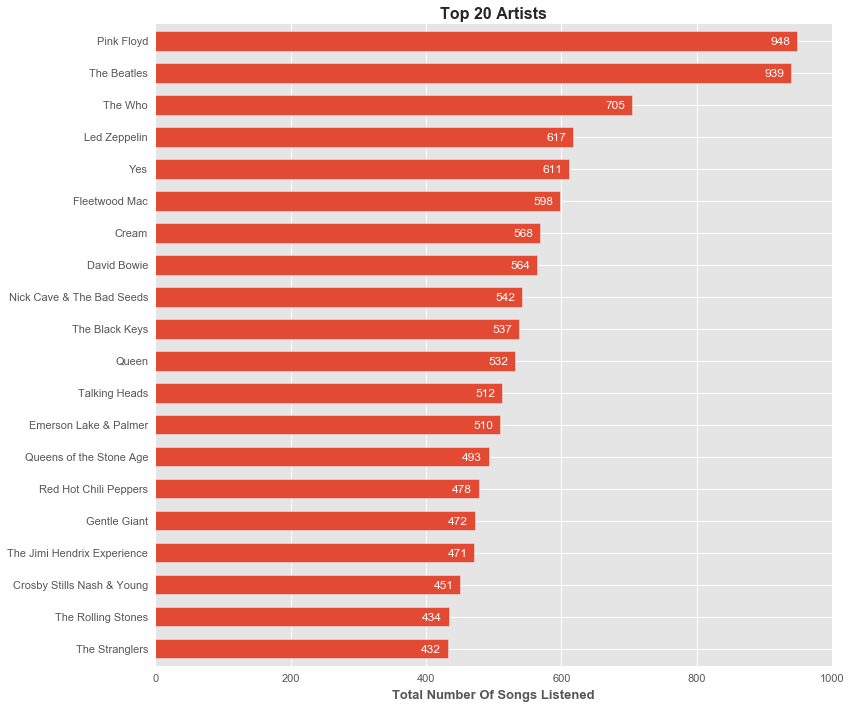

In [53]:
top_artists = df.Artist.value_counts(ascending=True)[-n_items:]
top_artists.rename('Artists', inplace=True)

plot_barh(top_artists, file_name='01_artists')

Pink Floyd and The Beatles stand out, way ahead of all other artists. 

If you're familiar with the artist names shown here, you'll see the pattern of listening to the bands from 1970's. And this is the result I expected to see.

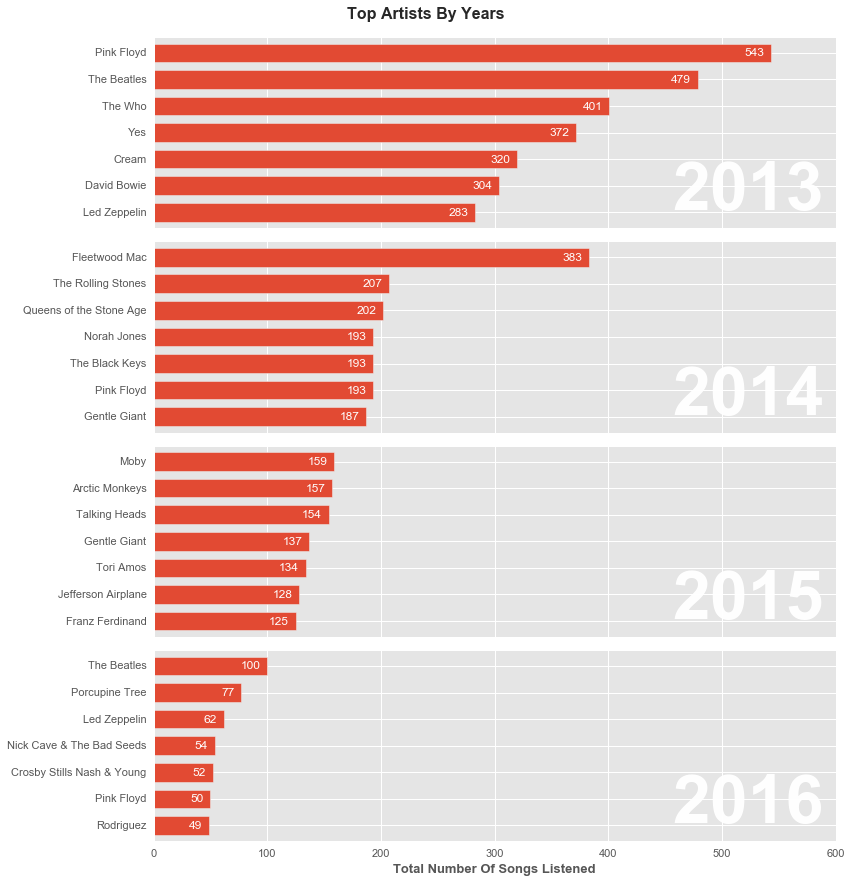

In [54]:
fig, axarr = plt.subplots(4, 1, figsize=(12,12), sharex=True)

fig.suptitle('Top Artists By Years', y=1.02)

for i, year in enumerate([2013, 2014, 2015, 2016]):
    ax = axarr[i]
    yearly_top = df[df.Date.dt.year == year].Artist.value_counts(ascending=True)[-7:]
    yearly_top.plot(kind='barh', width=0.7, ax=ax)
    ax.text(x=590, y=0.1, s=year, fontsize=68, color='white', 
            fontweight='bold', ha='right')

    for bar, value in zip(ax.patches, yearly_top.values):
        x = bar.get_width()
        y = bar.get_y()
        dx = ax.get_xbound()[1] / 100
        dy = bar.get_height() / 2
    
        ax.text(x-dx, y+dy, value, va='center', ha='right', color='white')

axarr[-1].set_xlabel('Total Number Of Songs Listened')
plt.tight_layout()

plt.savefig('./figures/lastfm_02_artists_year.png')

First thing that stands out is my obssesion with Fleetwood Mac in 2014 - almost double number of scrobbles than The Rolling Stones in the second place.

Back when I started scrobbling, my music library was limited, and the chart for 2013 shows it - at the top are only very popular bands, played a lot (less other artists to play).  
Next two years show increased number of artists I wouldn't expect to see as my top artists (Moby, Arctic Monkeys, New Order, etc.) One could say I was experimenting.

In 2014 I betrayed The Beatles and listened to The Rolling Stones a lot.  
And in 2015 I had enough of Pink Floyd (the only year where they don't show up in the top artists).

2016 is not yet finished, but I see a trend of coming back to basics - correlated with not visiting last.fm any more trying to find new artists to listen.

### Top albums

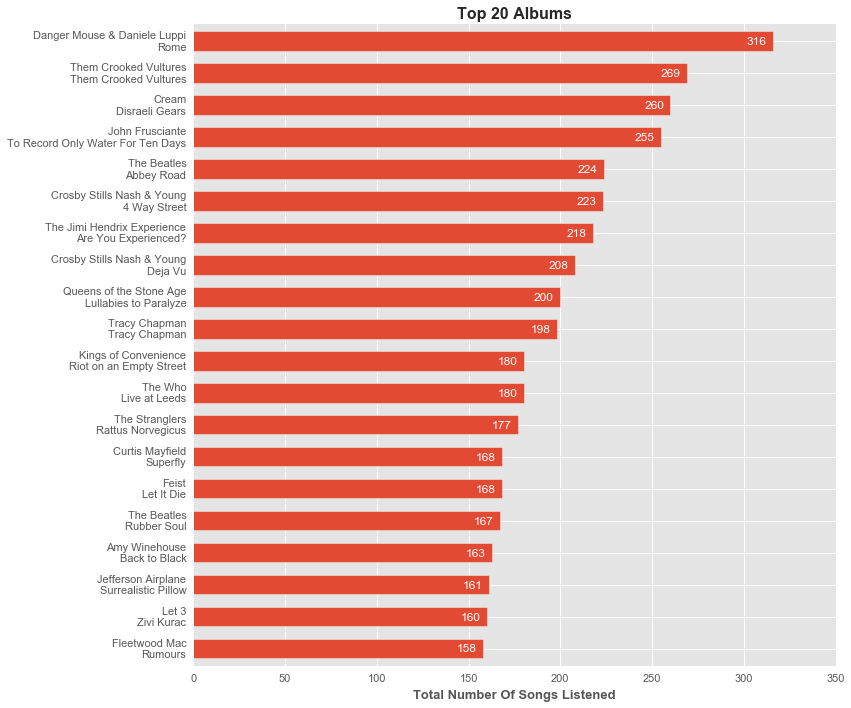

In [55]:
df_album = df.copy()

df_album['album_count'] = df_album.groupby(['Album', 'Artist'])['Date'].transform('count')

df_album = df_album.drop_duplicates(subset=['Album', 'Artist']).dropna().drop(['Date', 'Song'], axis=1)
df_album['album_count'] = df_album.album_count.astype(int)
df_album = df_album.sort_values(by='album_count', ascending=False).reset_index(drop=True)


top_albums = df_album[:n_items].copy()
top_albums = top_albums.sort_values(by='album_count')

index = top_albums.apply(lambda x: '{}\n{}'.format(x.Artist, x.Album), axis=1)
top_albums = top_albums.set_index(index).drop(['Artist', 'Album'], axis=1)
top_albums = top_albums.album_count.rename('Albums')


plot_barh(top_albums, file_name='03_albums')

"Rome" is a clear winner here, and I expected it to be near the top, because it is my go-to album when I have guests and need to quickly find something "nice and easy". (If you haven't listened it yet - what are you waiting for?)

"Them Crooked Vultures" is the only album from the same-named band, so if I want to listen to them, I have no choice.  
"Tracy Chapman", "Superfly", "To Record Water...", and "Let It Die" are not the only albums of their authors, but are my favourites.

There are two bands with two albums on this list: The Beatles and CSNY.

#### Note:  
Albums with high number of tracks are favoured by this list, because it measures the number of songs listened from each album, not the number of plays of the album and/or total time spent listening to some album.

### Top songs

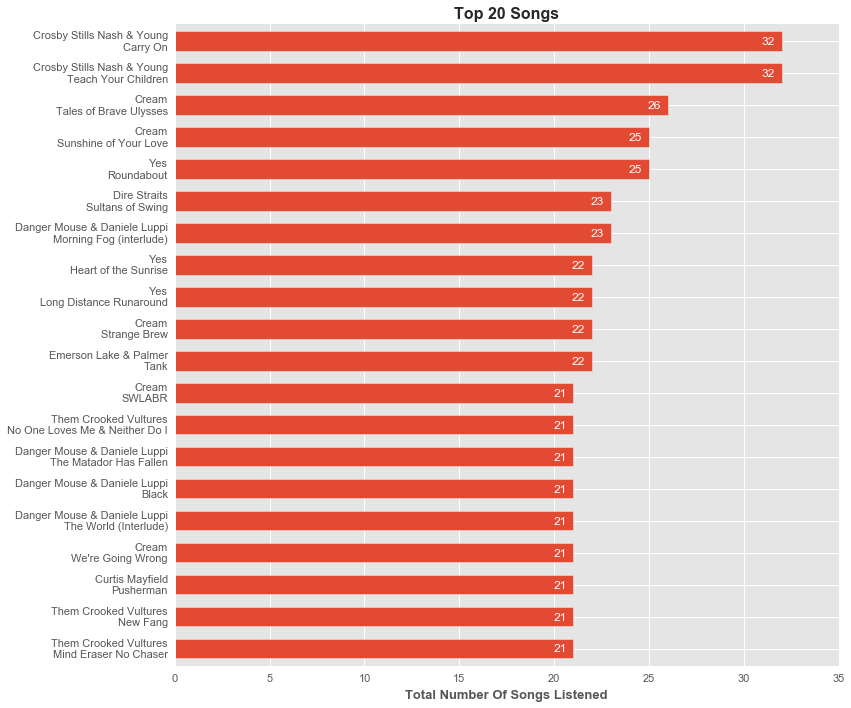

In [56]:
df_song = df.copy()

df_song['song_count'] = df_song.groupby(['Song', 'Artist'])['Date'].transform('count')

df_song = df_song.drop_duplicates(subset=['Song', 'Artist']).dropna().drop(['Date', 'Album'], axis=1)
df_song['song_count'] = df_song.song_count.astype(int)
df_song = df_song.sort_values(by='song_count', ascending=False).reset_index(drop=True)


top_songs = df_song[:n_items].copy()
top_songs = top_songs.sort_values(by='song_count')

index = top_songs.apply(lambda x: '{}\n{}'.format(x.Artist, x.Song), axis=1)
top_songs = top_songs.set_index(index).drop(['Artist', 'Song'], axis=1)
top_songs = top_songs.song_count.rename('Songs')


plot_barh(top_songs)

As expected, this chart isn't meaningful because of my listening habbits where I listen to whole albums, not just particular song(s).  
This list closely follows the number of times I've listened to the album from which the song is.

## Time data

In [57]:
extract_local_hour = lambda x: x.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('CET')).hour
    
df['year_month'] = df.Date.dt.strftime('%Y-%m')
df['day_of_week'] = df.Date.dt.strftime('%w').astype(int)
df['day_of_week'] = df.day_of_week.map(lambda x: 7 if x == 0 else x)
df['hour'] = df.Date.map(extract_local_hour)

### Monthly scrobbles

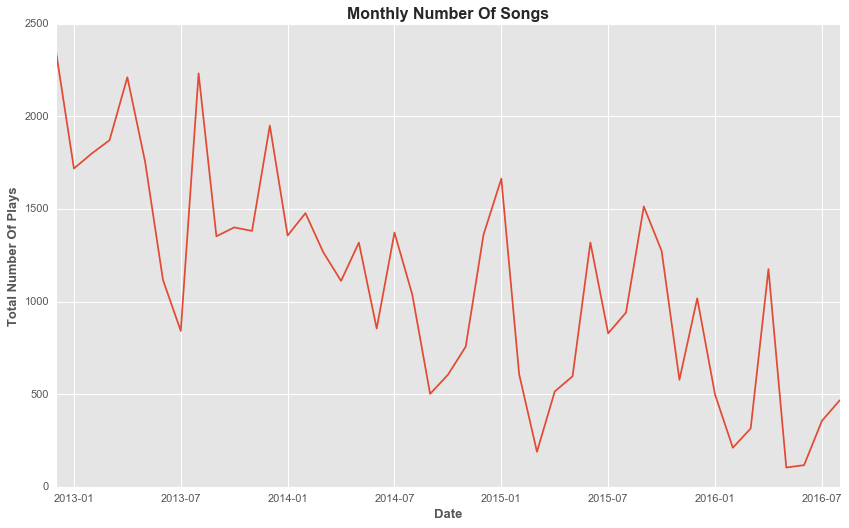

In [58]:
df_monthly = df.copy()

df_monthly['monthly_scrobbles'] = df_monthly.groupby('year_month')['Date'].transform('count')
df_monthly = df_monthly.drop_duplicates(subset='year_month')
df_monthly.sort_values(by='year_month', inplace=True)

monthly_scrobbles = df_monthly[['monthly_scrobbles']]
monthly_scrobbles.set_index(df_monthly.year_month, inplace=True)


ax = monthly_scrobbles.plot(kind='line', legend=False)

six_months = range(1, len(monthly_scrobbles), 6)
xlabels = monthly_scrobbles.iloc[six_months].index

_ = (ax.set_title('Monthly Number Of Songs'),
     ax.set_xlabel('Date'),
     ax.set_ylabel('Total Number Of Plays'),
     ax.set_xticks(six_months),
     ax.set_xticklabels(xlabels),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_04_history.png')

This chart shows something I expected to see, but I didn't thought it was this drastic - as the time goes by, I listen less and less of "my music".  
It's easier for me just to turn on the (internet) radio than to go trough my library and find something I would like to listen to.

If there's something I should learn from this exploration, it is: **I should (re-)start to listen more of the music from my library!**

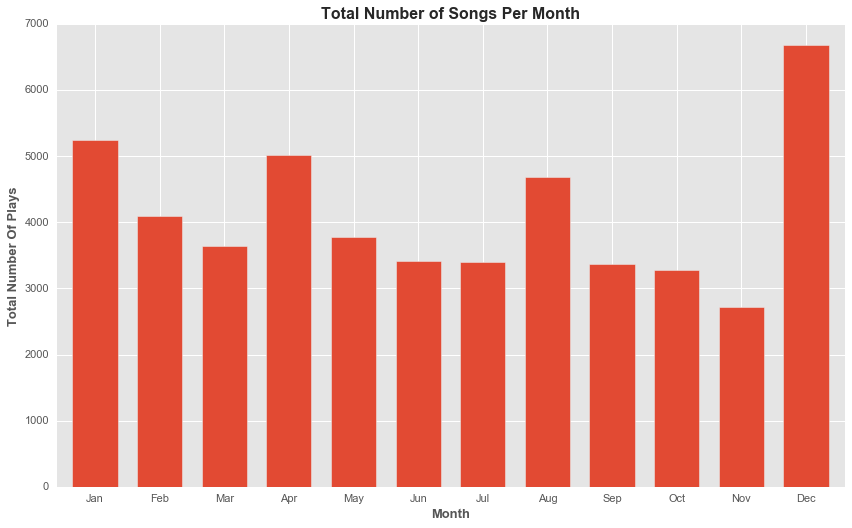

In [59]:
scrobbles_per_month = df.Date.dt.month.value_counts(sort=False)


ax = scrobbles_per_month.plot(kind='bar', width=0.7)

months = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()

_ = (ax.set_title('Total Number of Songs Per Month'),
     plt.xticks(rotation=0),
     ax.set_xticklabels(months),
     ax.set_xlabel('Month'),
     ax.set_ylabel('Total Number Of Plays'),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_05_monthly.png')

I expected to see uniform values across all months, but for some unknown reason - I really like listening my music in December.

### Day of the week

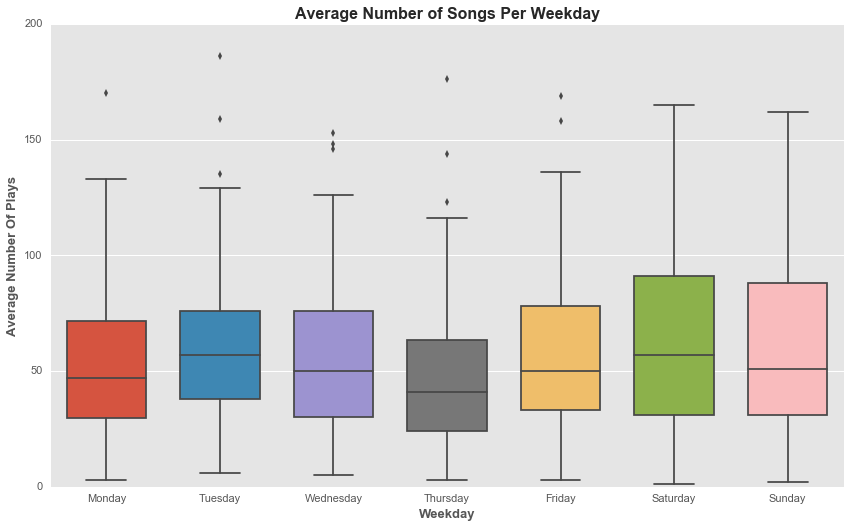

In [60]:
days = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()

scrobbles_per_day = df.groupby([df.day_of_week, df.Date.dt.date]).count()['Artist'].unstack(0)


ax = sns.boxplot(data=scrobbles_per_day, saturation=0.85, width=0.7)

_ = (ax.set_title('Average Number of Songs Per Weekday'),
     ax.set_xticklabels(days, rotation=0),
     ax.set_xlabel('Weekday'),
     ax.set_ylabel('Average Number Of Plays'),
     ax.set_ylim(0, 200),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_06_weekday.png')

More uniform than the monthly split (the chart above).  
I've expected to see higher values for the weekend.

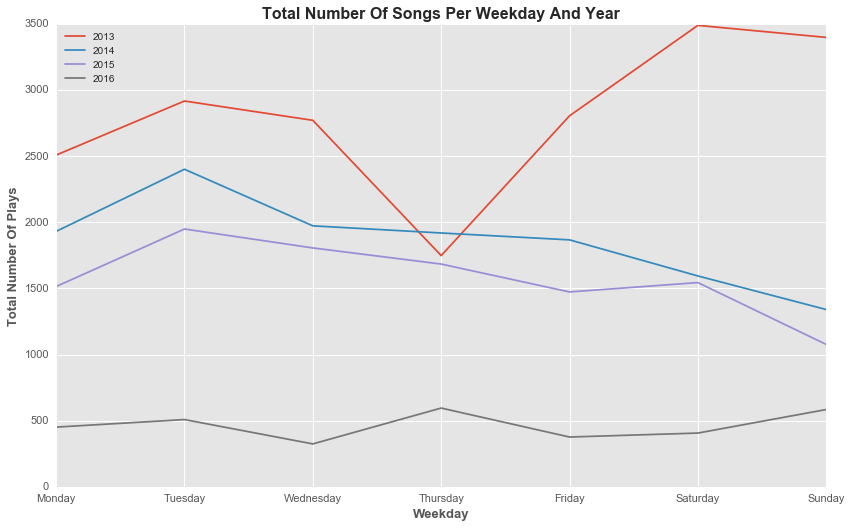

In [61]:
weekly_per_year = []
for year in [2013, 2014, 2015, 2016]:
    y = df.loc[df.Date.dt.year == year, 'day_of_week'].value_counts(sort=False).sort_index()
    weekly_per_year.append((year, y))

    
fig, ax = plt.subplots(1, 1)

for year, songs in weekly_per_year:
    songs.plot(kind='line', label=year, ax=ax)
    
_ = (ax.set_title('Total Number Of Songs Per Weekday And Year'),
     ax.set_xticklabels(days, rotation=0),
     ax.set_xlabel('Weekday'),
     ax.set_ylabel('Total Number Of Plays'),
     plt.legend(loc=2),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_07_week_year.png')

In the previous chart there was slight drop on Thursdays, and now we can see why - in 2013 for some unknown reason I really didn't like to listen to music on Thursdays.

### Top 5 artists listening history

In [62]:
df_top_artists = df[df.Artist.isin(top_artists.tail(5).index)]
artists_by_month = df_top_artists.groupby(['Artist', 'year_month']).count()['Date']

artists_historical = artists_by_month.unstack(0).cumsum().fillna(method='ffill')

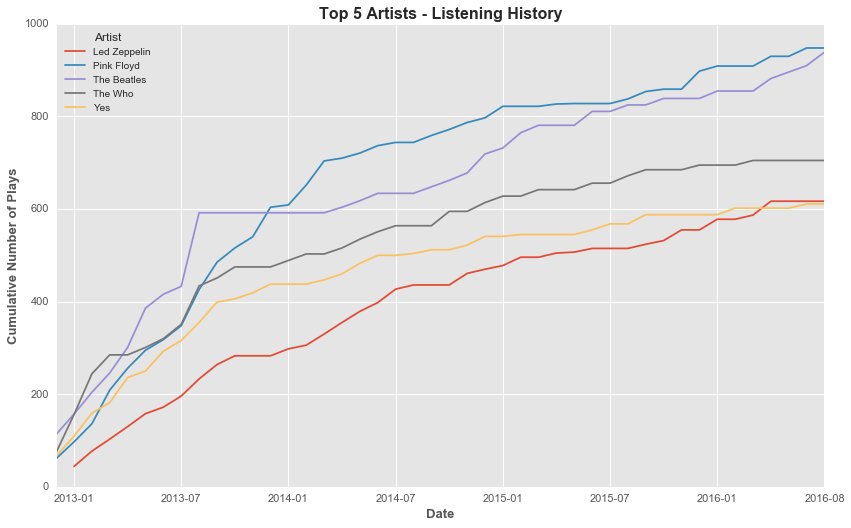

In [63]:
ax = artists_historical.plot()

six_months = range(1, artists_historical.shape[0], 6)
xlabels = artists_historical.iloc[six_months].index

_ = (ax.set_title('Top 5 Artists - Listening History'),
     ax.set_xlabel('Date'),
     ax.set_ylabel('Cumulative Number of Plays'),
     ax.set_xticks(six_months),
     ax.set_xticklabels(xlabels),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_08_artists_cumsum.png')

The most interesting part of this chart is:
* Beatle-mania - from the beginning of scrobbling until August 2013
* Beatle-fobia - in the next 7 months after Beatle-mania, exactly zero songs by The Beatles, the result of previous overloading

Other than that, The Beatles and Pink Floyd seem to be resistant to my decline in music listening in recent months. Even if I listen much less, I'll always find the time for these two.

### Time of the day

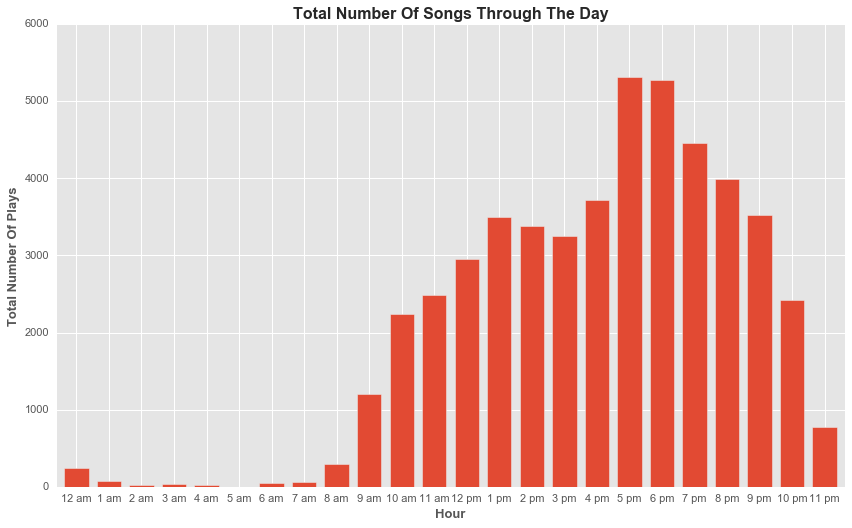

In [64]:
h = ['{} {}'.format(x, ampm) for ampm in ['am', 'pm'] for x in range(12)]
h[0], h[12] = '12 am', '12 pm'


scrobbles_per_hour = df.hour.value_counts(sort=False)
# not a single song between 5 and 6 am - add the value
scrobbles_per_hour = scrobbles_per_hour.append(pd.Series({5: 0})).sort_index()


ax = scrobbles_per_hour.plot(kind='bar', width=0.75)

_ = (ax.set_title('Total Number Of Songs Through The Day'),
     plt.xticks(rotation=0),
     ax.set_xticklabels(h),
     ax.set_xlabel('Hour'),
     ax.set_ylabel('Total Number Of Plays'),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_09_time.png')

Can you guess my sleeping habits? ;)

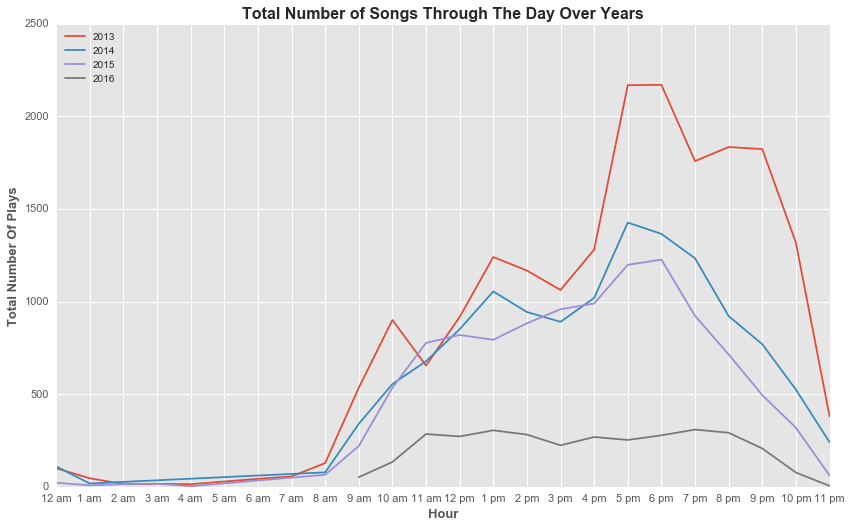

In [65]:
hourly_per_year = []
for year in [2013, 2014, 2015, 2016]:
    y = df.loc[df.Date.dt.year == year, 'hour'].value_counts(sort=False).sort_index()
    hourly_per_year.append((year, y))

    
fig, ax = plt.subplots(1, 1)

for year, songs in hourly_per_year:
    songs.plot(kind='line', label=year, ax=ax)
    
_ = (ax.set_title('Total Number of Songs Through The Day Over Years'),
     ax.set_xticks(range(24)),
     ax.set_xticklabels(h),
     ax.set_xlabel('Hour'),
     ax.set_ylabel('Total Number Of Plays'),
     plt.legend(loc=2),
     plt.tight_layout()
    )

plt.savefig('./figures/lastfm_10_time_year.png')

Not only can you see my sleeping habits, but sudden increase around 5 PM can tell you when I was working (from 8 am to 4 pm) for a whole year (2013), just part of the year (2014, 2015), and when I was unemployed for a whole year (2016).

You could also say that the more I work, the more I listen to the music throughout the day.

# Conclusions

* total 49k scrobbles
* 594 different artists, 1454 different albums, 14k different songs
* initially, 1800 entries (3.5%) had missing album values; after cleaning: 120 of them (less than 0.3%)
* I really like the bands from 1970's
* Danger Mouse's "Rome" is my favourite music album
* somehow I really like music in December
* in 2013 I really didn't like music on Thursdays
* 2014 and 2015 were my "experimental years"

And the most important:
* I should (re-)start to listen more of the music from my library - by getting a job ;)

#### Notebook Style

In [66]:
from IPython.core.display import HTML
def css_styling(): 
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()